# Regression modeling using only Traffic Data

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pprint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import xgboost as xgb
%matplotlib inline


In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_csv("./data/WA_cngstn.csv")

In [4]:
df.head()

,Type,Severity,TMC,StartTime(UTC),EndTime(UTC),LocationLat,LocationLng,Distance(mi),Side,ZipCode,IsAnomaly,Duration
0,3,1,74,2016-11-30 23:35:00,2016-12-01 00:55:09,47.01,-122.91,1.49,-1,98501.00,0,80
1,3,2,73,2016-12-01 00:52:00,2016-12-01 01:04:04,47.61,-122.33,1.49,-1,98104.00,0,12
2,3,1,74,2016-12-01 01:08:00,2016-12-01 01:26:07,47.96,-122.20,2.30,-1,98203.00,0,18
3,3,1,74,2016-12-01 01:02:00,2016-12-01 01:24:00,47.56,-122.19,2.59,-1,98006.00,0,22
4,3,1,74,2016-12-01 01:19:00,2016-12-01 01:31:07,47.62,-122.33,1.64,-1,98101.00,0,12


In [5]:
df_prune = df.drop(['Type', 'TMC', 'Distance(mi)', 'EndTime(UTC)', 'Side', 'IsAnomaly', 'ZipCode'], axis = 1)

In [6]:
df_prune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558781 entries, 0 to 558780
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Severity        558781 non-null  int64  
 1   StartTime(UTC)  558781 non-null  object 
 2   LocationLat     558781 non-null  float64
 3   LocationLng     558781 non-null  float64
 4   Duration        558781 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 21.3+ MB


In [7]:
def Mon(x):
    return x.split(" ")[0].split('-')[1]
def Day(x):
    return x.split(" ")[0].split('-')[2]
def Hour(x):
    return x.split(" ")[1].split(':')[0]
def Minute(x):
    return x.split(" ")[1].split(':')[1]

In [8]:
df_prune['StartMonth'] = df_prune['StartTime(UTC)'].apply(lambda x: Mon(x)).astype(int)
df_prune['StartDay'] = df_prune['StartTime(UTC)'].apply(lambda x: Day(x)).astype(int)
df_prune['StartHour'] = df_prune['StartTime(UTC)'].apply(lambda x: Hour(x)).astype(int)
df_prune['StartMinute'] = df_prune['StartTime(UTC)'].apply(lambda x: Minute(x)).astype(int)

In [10]:
df_prune.drop('StartTime(UTC)', inplace=True, axis = 1)

In [11]:
df_prune.isnull().sum().sum()

0

In [12]:
len(df_prune)

558781

In [13]:
df_prune.dropna(inplace=True)

In [14]:
df_prune.head()

,Severity,LocationLat,LocationLng,Duration,StartMonth,StartDay,StartHour,StartMinute
0,1,47.01,-122.91,80,11,30,23,35
1,2,47.61,-122.33,12,12,1,0,52
2,1,47.96,-122.20,18,12,1,1,8
3,1,47.56,-122.19,22,12,1,1,2
4,1,47.62,-122.33,12,12,1,1,19


In [79]:
def RSquare(df, col):
    X, y = df.drop(col,axis=1), df[col]

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 50)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly_r2s, cv_lasso_r2s = [], [], [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)
        lm_poly = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
#         cv_lm_r2s.append(lm.score(X_tra, y_tra))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

        poly = PolynomialFeatures(degree=2) 
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        lm_poly.fit(X_train_poly, y_train)
        cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
        
        #Lasso
        std = StandardScaler()
        std.fit(X_train)
        
        X_tr = std.transform(X_train)
        X_te = std.transform(X_test)
        
        X_val_lasso = std.transform(X_val)
        
        alphavec = 10**np.linspace(-10,10,1000)

        lasso_model = LassoCV(alphas = alphavec, cv=5)
        lasso_model.fit(X_tr, y_train)
        cv_lasso_r2s.append(lasso_model.score(X_val_lasso, y_val))
        
        test_set_pred = lasso_model.predict(X_te)
        
        column = df.drop(col,axis=1)
        to_print = list(zip(column.columns, lasso_model.coef_))
        pp = pprint.PrettyPrinter(indent = 1)
    
        rms = sqrt(mean_squared_error(y_test, test_set_pred))
        
    print('Simple regression scores: ', cv_lm_r2s, '\n')
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')
    print('Poly scores: ', cv_lm_poly_r2s, '\n')
    print('Lasso scores: ', cv_lasso_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}', '\n')
    
    print('lasso_model.alpha_:', lasso_model.alpha_)
    print(f'Lasso cv r^2: {r2_score(y_test, test_set_pred):.3f} +- {np.std(cv_lasso_r2s):.3f}', '\n')
    
    print(f'MAE: {mae(y_test, test_set_pred)}', '\n')
    print('RMSE:', rms, '\n')
    mse = mean_squared_error(y_test, test_set_pred)
    print('MSE:', mse, '\n')
    
    print('Lasso Coef:')
    pp.pprint (to_print)

In [80]:
# 'Mean absolute error'
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [81]:
RSquare(df_prune, 'Duration')

Simple regression scores:  [0.011881216794002003, 0.004016228473652683, 0.004540670989232609, 0.004073900792589735, 0.0037630548765654743] 

Ridge scores:  [0.011881215191225536, 0.004016227830644703, 0.004540670337045083, 0.004073901386682954, 0.0037630564024189184] 

Poly scores:  [0.015686675319934063, 0.0059662711641566, 0.0065521151489673635, 0.005829463405861657, 0.005238228678359769] 

Lasso scores:  [0.011881151099229825, 0.004016228473637806, 0.004540658962475241, 0.0040739112961623025, 0.0037630548766027783] 

Simple mean cv r^2: 0.006 +- 0.003
Ridge mean cv r^2: 0.006 +- 0.003
Poly mean cv r^2: 0.008 +- 0.004 

lasso_model.alpha_: 3.4716868189265595e-10
Lasso cv r^2: 0.012 +- 0.003 

MAE: 22.717330375012974 

RMSE: 78.04654722431233 

Lasso Coef:
[('Severity', 3.5229681599873177),
 ('LocationLat', -0.5285480617093276),
 ('LocationLng', -3.349335807896384),
 ('StartMonth', 2.6614630826944343),
 ('StartDay', 0.5567129958486456),
 ('StartHour', 6.542225141820619),
 ('StartMinut

## Split dataset

In [50]:
X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=13)

In [51]:
# X_train, X_validate, X_test = np.split(X.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
# y_train, y_validate, y_test = np.split(y.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [52]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [53]:
train, validate, test = train_validate_test_split(df_prune)
X_train, y_train = train.drop('Duration',axis=1), train['Duration']
X_validate, y_validate = validate.drop('Duration',axis=1), validate['Duration']
X_test, y_test = test.drop('Duration',axis=1), test['Duration']

## Gradient Boosting

In [40]:
params = {'n_estimators': 1000,
          'max_depth': 5,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [41]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_validate, reg.predict(X_validate))
r2 = r2_score(y_validate, reg.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R^2 on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 7233.9365
The R^2 on test set: 0.3987


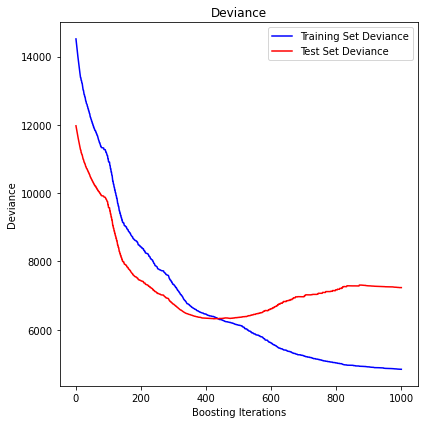

In [42]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_validate)):
    test_score[i] = reg.loss_(y_validate, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [54]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

In [55]:
est = HistGradientBoostingRegressor().fit(X_train, y_train)
est.score(X_validate, y_validate)

0.11650155397946815

In [45]:
X_validate

,Severity,LocationLat,LocationLng,StartMonth,StartDay,StartHour,StartMinute
235631,2,47.16,-122.30,4,5,18,36
18299,3,47.61,-122.33,1,14,2,17
64876,1,47.49,-122.19,2,9,1,55
370076,1,45.67,-122.58,8,26,20,54
84955,1,47.27,-122.32,4,13,3,4
...,...,...,...,...,...,...,...
57719,2,46.93,-122.99,9,8,5,16
554349,3,46.37,-120.32,8,22,2,8
243134,3,47.03,-122.89,4,21,22,52
169610,3,47.30,-122.23,9,16,23,27


In [46]:
est.predict([[3, 47.70, -122.60, 5, 30, 20, 43]])

array([51.63584419])

In [47]:
mse = mean_squared_error(y_validate, est.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 5993.4604


In [48]:
rms = sqrt(mse)
print('RMSE:', rms, '\n')

RMSE: 77.4174421888909 



## Supervised Deep Neural Networks

In [113]:
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(X_test)  # doctest: +SKIP

In [115]:
from sklearn.neural_network import MLPRegressor

In [116]:
regr = MLPRegressor(random_state=1, max_iter=500, early_stopping=True, verbose=True).fit(X_train, y_train)
regr.score(X_test, y_test)

Iteration 1, loss = 6834.10477709
Validation score: 0.005963
Iteration 2, loss = 6626.90556155
Validation score: 0.008381
Iteration 3, loss = 6616.61288644
Validation score: 0.009270
Iteration 4, loss = 6610.80275983
Validation score: 0.010055
Iteration 5, loss = 6606.90301941
Validation score: 0.010191
Iteration 6, loss = 6603.57041181
Validation score: 0.011024
Iteration 7, loss = 6600.66164238
Validation score: 0.011243
Iteration 8, loss = 6597.99350315
Validation score: 0.011808
Iteration 9, loss = 6596.22365669
Validation score: 0.011959
Iteration 10, loss = 6594.23899922
Validation score: 0.012104
Iteration 11, loss = 6593.31462819
Validation score: 0.012403
Iteration 12, loss = 6591.96962101
Validation score: 0.012507
Iteration 13, loss = 6590.60762138
Validation score: 0.012700
Iteration 14, loss = 6589.56225751
Validation score: 0.013007
Iteration 15, loss = 6588.51495103
Validation score: 0.012997
Iteration 16, loss = 6587.67083599
Validation score: 0.013257
Iteration 17, los

Iteration 133, loss = 6532.21152257
Validation score: 0.023859
Iteration 134, loss = 6532.31558227
Validation score: 0.023731
Iteration 135, loss = 6531.81312927
Validation score: 0.023320
Iteration 136, loss = 6531.05576716
Validation score: 0.022048
Iteration 137, loss = 6530.85785226
Validation score: 0.023859
Iteration 138, loss = 6530.73459016
Validation score: 0.023797
Iteration 139, loss = 6530.33479239
Validation score: 0.023075
Iteration 140, loss = 6530.11530241
Validation score: 0.024255
Iteration 141, loss = 6529.29923162
Validation score: 0.024420
Iteration 142, loss = 6529.00717628
Validation score: 0.024353
Iteration 143, loss = 6528.23330953
Validation score: 0.024484
Iteration 144, loss = 6528.41253503
Validation score: 0.024602
Iteration 145, loss = 6527.94806809
Validation score: 0.024701
Iteration 146, loss = 6527.31620783
Validation score: 0.024826
Iteration 147, loss = 6527.06872040
Validation score: 0.024947
Iteration 148, loss = 6526.66903207
Validation score: 0

Iteration 264, loss = 6488.08884679
Validation score: 0.032793
Iteration 265, loss = 6488.40854982
Validation score: 0.033008
Iteration 266, loss = 6487.88459475
Validation score: 0.033020
Iteration 267, loss = 6487.89433610
Validation score: 0.032808
Iteration 268, loss = 6487.85835852
Validation score: 0.033372
Iteration 269, loss = 6487.10902538
Validation score: 0.033223
Iteration 270, loss = 6486.87010130
Validation score: 0.033267
Iteration 271, loss = 6486.77051268
Validation score: 0.033435
Iteration 272, loss = 6486.53294622
Validation score: 0.033538
Iteration 273, loss = 6485.87786353
Validation score: 0.033281
Iteration 274, loss = 6485.84305991
Validation score: 0.032891
Iteration 275, loss = 6485.94376912
Validation score: 0.033580
Iteration 276, loss = 6485.41798822
Validation score: 0.033714
Iteration 277, loss = 6484.77552399
Validation score: 0.033527
Iteration 278, loss = 6485.45197989
Validation score: 0.033650
Iteration 279, loss = 6484.65544688
Validation score: 0

0.01913458534248902

## Keras

In [14]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [21]:
import tensorflow as tf

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Visible devices cannot be modified after being initialized


In [20]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [15]:
train, test = train_test_split(df_prune, test_size = 0.2)
target = train.Duration
train.drop(['Duration'],axis = 1 , inplace = True)

F:\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
# X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
# train, test = train_test_split(X, test_size = 0.2)

##### Do not run the line below, it's too GPU intensive to run on local machine

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [18]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(train, target, epochs=50, batch_size=10, validation_split = 0.2, callbacks=callbacks_list)

In [ ]:
# Weights-488--18.80487.hdf5

In [ ]:
wights_file = './models/Weights-488--18.80487.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Epoch 00499: val_loss did not improve from 18.80487
Epoch 500/500
357619/357619 [==============================] - 10s 29us/step - loss: 18.3375 - mean_absolute_error: 18.3375 - val_loss: 18.8967 - val_mean_absolute_error: 18.8967

r2_score(test.Duration, predictions)

0.0007101090759975559

# Conclusion

##### Best Model is Gradient Boosting

In [18]:
import pickle

In [28]:
pickle.dump(est, open("./models/GB_Duration.pickle.dat", "wb"))

In [19]:
# load model from file
loaded_model = pickle.load(open("./models/GB_Duration.pickle.dat", "rb"))

In [20]:
chk_anomaly = pd.DataFrame(loaded_model.predict(X_test))

In [24]:
len(chk_anomaly)

55879

In [23]:
chk_anomaly[chk_anomaly[0] >= 123]

,0
4,142.54
109,171.13
376,125.20
417,124.53
421,164.82
...,...
55307,142.12
55487,136.19
55543,174.27
55605,167.92
